## Notebook Configuration && Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd

from storesales.utils import load_oil, load_stores, save_submission, make_submission_forecast_plot
from storesales.feature_engineering import create_date_features
from storesales.preprocessing import preprocess

from storesales.advanced_predictor import AdvancedPredictor
from storesales.light_gbm.lgb_tuner.family_lgb_params import (
    FamilyLightGBMModelParams,
    FamilyLightGBMModelBaseParams,
)
from storesales.light_gbm.lgb_tuner.lgb_model_tuner import LightGBMModelTuner

from storesales.light_gbm.fit_evaluate.evaluate_models import evaluate
from storesales.light_gbm.feature_engineering.rolls_to_features import (
    Roll,
    make_featured_df_from_rolls,
)
from storesales.light_gbm.feature_engineering.rolling_window_params import (
    get_custom_minimal_fc_parameters,
)
from storesales.light_gbm.dataset import make_family_datasets
from storesales.light_gbm.utils import (
    make_submission_predictions,
    print_models_params,
    plot_feature_importance,
)
from storesales.light_gbm.constants import (
    TRAINING_DATA_THRESHOLD_TIMESTAMP,
    ROLLS_THRESHOLD_TIMESTAMP,
    FEATURES_TO_ROLL,
    START_TARGET_SERIES_TIMESTAMP,
    STATIC_COLS,
    CAT_STATIC_COVS,
    CAT_FUTURE_COVS,
)
from storesales.constants import (
    TEST_DATE_RANGE,
    VALIDATION_DATE_RANGE,
    START_SUBMISSION_DATE,
    START_VALIDATION_DATE,
    MIDDLE_TEST_DATE,
    EXTERNAL_TRAIN_PATH,
    EXTERNAL_TEST_PATH,
    EXTERNAL_OIL_PATH,
    EXTERNAL_STORES_PATH,
)

In [2]:
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

## Load && Preprocess Data

In [3]:
train_df = pd.read_csv(EXTERNAL_TRAIN_PATH, parse_dates=["date"])
test_df = pd.read_csv(EXTERNAL_TEST_PATH, parse_dates=["date"])

In [4]:
stores_df = load_stores(EXTERNAL_STORES_PATH, factorize_cols=["city", "state", "type"])
oil_df = load_oil(EXTERNAL_OIL_PATH)

In [5]:
preprocessed_df = preprocess(train_df, remove_zero_gaps=False)

## Darts LightGBM Implementation
### Make Family Datasets

#### Prepare Data Before Making Rolling Features
1. concatenate `preprocessed_df` and `test_df` in `data_df` to get past and future values in one df;
2. fill test period sales with 0;
3. select specific `families` for LightGBM models;
4. merge `oil_df` and `stores_df` to `data_df`;
5. filter data with `TRAINING_DATA_THRESHOLD_TIMESTAMP` to get enough data to train LightGBM models.



In [6]:
# families = ["EGGS", "DAIRY", "LIQUOR,WINE,BEER", "PREPARED FOODS", "PRODUCE", "SEAFOOD"]
families = ["SCHOOL AND OFFICE SUPPLIES"]

In [7]:
data_df = pd.concat([preprocessed_df, test_df], ignore_index=True)  # 1.

data_df.fillna(0, inplace=True)  # 2.

data_df = data_df[data_df["family"].isin(families)].copy()  # 3.

data_df = data_df.merge(oil_df, left_on="date", right_index=True, how="left")  # 4.
data_df = data_df.merge(stores_df, on="store_nbr", how="left")

min_group_date = data_df.groupby(["family", "store_nbr"])["date"].transform("min")
filtered_data_df = data_df[min_group_date <= TRAINING_DATA_THRESHOLD_TIMESTAMP]  # 5.

In [8]:
class SalesPromoScaler:
    def __init__(self):
        self.min_sales = dict()
        self.max_sales = dict()
        self.min_promo = dict()
        self.max_promo = dict()

    def fit(self, df: pd.DataFrame) -> None:
        df_grouped = df.groupby(["family", "store_nbr"])
        for (family, store_nbr), group in df_grouped:
            self.min_sales[(family, store_nbr)] = group["sales"].min()
            self.max_sales[(family, store_nbr)] = group["sales"].max()

            self.min_promo[(family, store_nbr)] = group["onpromotion"].min()
            self.max_promo[(family, store_nbr)] = group["onpromotion"].max()

    def transform_column(self, col, min_val, max_val):
        return (col - min_val) / (max_val - min_val + 1e-9)

    def transform(self, df: pd.DataFrame) -> None:
        df_grouped = df.groupby(["family", "store_nbr"])
        for (family, store_nbr), group in df_grouped:
            df.loc[group.index, "sales"] = self.transform_column(
                col=group["sales"],
                min_val=self.min_sales[(family, store_nbr)],
                max_val=self.max_sales[(family, store_nbr)],
            )
            df.loc[group.index, "onpromotion"] = self.transform_column(
                col=group["onpromotion"],
                min_val=self.min_promo[(family, store_nbr)],
                max_val=self.max_promo[(family, store_nbr)],
            )

    def inverse_transform(self, df: pd.DataFrame) -> None:
        df_grouped = df.groupby(["family", "store_nbr"])
        for (family, store_nbr), group in df_grouped:
            numerator = group["sales"] * (
                self.max_sales[(family, store_nbr)]
                - self.min_sales[(family, store_nbr)]
            )
            df.loc[group.index, "sales"] = (
                numerator + self.min_sales[(family, store_nbr)]
            )

    def inverse_transform_by_key(self, values, family, store_nbr) -> None:
        numerator = values * (
            self.max_sales[(family, store_nbr)] - self.min_sales[(family, store_nbr)]
        )
        return numerator + self.min_sales[(family, store_nbr)]

In [9]:
scaler = SalesPromoScaler()

scaler.fit(filtered_data_df[filtered_data_df["date"] < START_VALIDATION_DATE])
scaler.transform(filtered_data_df)

#### Rolling Features
I'll make two types of roll features: with short and long windows.   
Combined DataFrame will have features with `short` and `long` suffixes.

In [10]:
rolls_data_con = filtered_data_df["date"] >= ROLLS_THRESHOLD_TIMESTAMP
rolls_data_df = filtered_data_df[rolls_data_con].copy()

##### Define Short Roll

In [12]:
# default_fc_parameters = {"mean": None, "standard_deviation": None}

In [11]:
short_default_fc_parameters = get_custom_minimal_fc_parameters(
    number_peaks_n=[1],
    autocorrelation_lag=[1, 2],
    partial_autocorrelation_lag=[1, 2],
)
# short_default_fc_parameters = default_fc_parameters

short_rolls = Roll(
    name="short",
    timeshift=7,
    features=FEATURES_TO_ROLL,
    default_fc_parameters=short_default_fc_parameters,
)

##### Define Long Roll

In [12]:
long_default_fc_parameters = get_custom_minimal_fc_parameters(
    number_peaks_n=[1, 5],
    autocorrelation_lag=[2, 5, 10],
    partial_autocorrelation_lag=[2, 5, 10],
)
# long_default_fc_parameters = default_fc_parameters

long_rolls = Roll(
    name="long",
    timeshift=28,
    features=FEATURES_TO_ROLL,
    default_fc_parameters=long_default_fc_parameters,
)

##### Make Rolling Features

In [13]:
train_featured_df = make_featured_df_from_rolls(
    df=rolls_data_df, rolls=[short_rolls, long_rolls]
)

Feature Extraction: 100%|██████████| 30/30 [01:04<00:00,  2.14s/it]


#### Add Date Features
Add date features to `train_featured_df`.

In [14]:
date_features_df = create_date_features(train_featured_df, pref="date_feature_")
date_feature_cols = date_features_df.columns.to_list()

In [15]:
train_featured_df[date_feature_cols] = date_features_df

#### Specify Lags

In [16]:
# featured columns
sales_cols = [col for col in train_featured_df.columns if "sales_" in col]
onpromotion_cols = [col for col in train_featured_df.columns if "onpromotion_" in col]
oil_cols = [col for col in train_featured_df.columns if "dcoilwtico_" in col]

# onpromotion and oil features are future covariates
future_short_cols = [col for col in onpromotion_cols + oil_cols if "short" in col]
future_long_cols = [col for col in onpromotion_cols + oil_cols if "long" in col]

# sales features are past covariates
past_short_cols = [col for col in sales_cols if "short" in col]
past_long_cols = [col for col in sales_cols if "long" in col]

In [17]:
prev_season_short_lags = [-30, -34, -38, -42, -46]
prev_season_long_lags = [-30, -38, -46]

lags_past_short_covariates = [i for i in range(-16, -47, -1)]
lags_past_long_covariates = [i for i in range(-16, -47, -1)]

lags_future_short_covariates = [i for i in range(0, -17, -1)]
lags_future_long_covariates = [i for i in range(0, -17, -1)]

lags_date_feature_covariates = [i for i in range(-16, -47, -1)]

dcoilwtico_values_lags = [i for i in range(0, -50, -1)]
onpromotion_values_lags = [i for i in range(0, -46, -1)]

In [18]:
# future covariates lags
date_lags = {col: lags_date_feature_covariates for col in date_feature_cols}
future_short_lags = {col: lags_future_short_covariates for col in future_short_cols}
future_long_lags = {col: lags_future_long_covariates for col in future_long_cols}
dcoilwtico_lags = {"dcoilwtico": dcoilwtico_values_lags}
onpromotion_lags = {"onpromotion": onpromotion_values_lags}

# past covariates lags
past_short_lags = {col: lags_past_short_covariates for col in past_short_cols}
past_long_lags = {col: lags_past_long_covariates for col in past_long_cols}

In [19]:
series_lags = {"sales": [i for i in range(-1, -65, -1)]}
lags_future_covariates = {
    **future_short_lags,
    **future_long_lags,
    **date_lags,
    **dcoilwtico_lags,
    **onpromotion_lags,
}
lags_past_covariates = {**past_short_lags, **past_long_lags}

#### Make Family Datasets

In [20]:
start_series_con = filtered_data_df["date"] > START_TARGET_SERIES_TIMESTAMP
series_data = filtered_data_df[start_series_con].copy()

In [21]:
family_datasets = make_family_datasets(
    df=series_data,
    scaler=scaler,
    series_value_column="sales",
    featured_df=train_featured_df,
    static_cols=STATIC_COLS,
    future_cols=list(lags_future_covariates.keys()),
    past_cols=list(lags_past_covariates.keys()),
    train_end_date=START_VALIDATION_DATE,
    start_submission_date=START_SUBMISSION_DATE,
)

In [22]:
family_datasets.keys()

dict_keys(['SCHOOL AND OFFICE SUPPLIES'])

### Tune && Eval LightGBM Models
#### Tune Models

In [26]:
lags_past_covariates = list(range(-16, -23, -1))
lags_future_covariates = (14, 1)
series_lags = 65

In [27]:
# param_suggestor_class = FamilyLightGBMModelParams
param_suggestor_class = FamilyLightGBMModelBaseParams

param_suggestor = param_suggestor_class(
    n_jobs=6,
    lags=series_lags,
    lags_future_covariates=lags_future_covariates,
    lags_past_covariates=lags_past_covariates,
    # categorical_static_covariates=CAT_STATIC_COVS,
    # categorical_future_covariates=CAT_FUTURE_COVS,
)

In [28]:
tuner = LightGBMModelTuner(
    family_datasets=family_datasets, families=families, param_suggestor=param_suggestor
)

In [29]:
tuner.run_parallel_tune(
    evaluate_range=VALIDATION_DATE_RANGE, n_jobs=6, eval_stride=1, n_trials=1
)

Best trial: 0. Best value: 0.655008: 100%|██████████| 1/1 [00:31<00:00, 31.87s/it]



#### Fit Best Models

In [30]:
best_lgb_models = tuner.fit_best(n_jobs=6)

In [31]:
print_models_params(best_lgb_models)

SCHOOL AND OFFICE SUPPLIES:
	- max_depth: -1
	- num_leaves: 31
	- learning_rate: 0.05339023900239792
	- n_estimators: 100


AttributeError: 'LGBMRegressor' object has no attribute 'top_rate'

In [95]:
print_models_params(best_lgb_models)

PREPARED FOODS:
	- max_depth: 7
	- num_leaves: 48
	- learning_rate: 0.09926924563296899
	- n_estimators: 132
	- top_rate: 0.2999197902565672
	- other_rate: 0.4481628716166426
	- max_bin: 299
	- feature_fraction: 0.19942661574363207
	- max_cat_threshold: 5
	- data_sample_strategy: goss




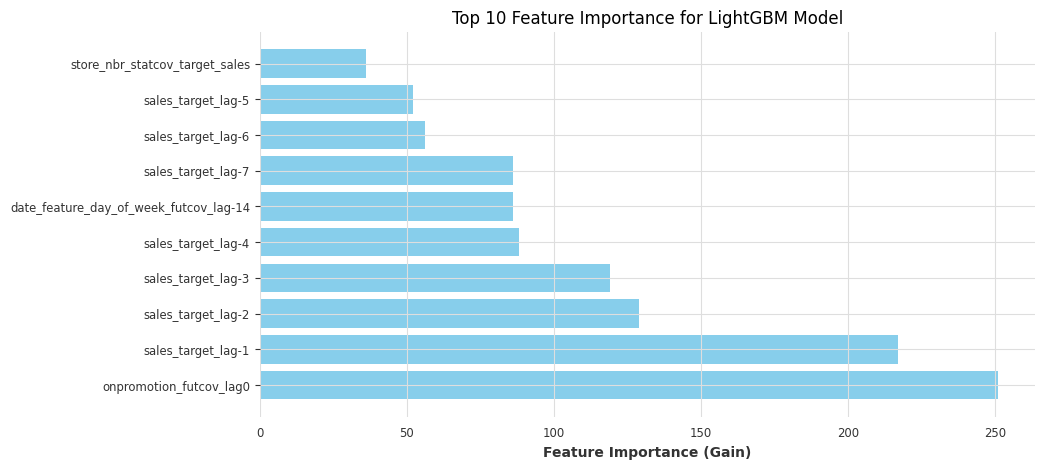

In [49]:
plot_feature_importance(best_lgb_models["SCHOOL AND OFFICE SUPPLIES"], 10)

#### Evaluate Models

In [31]:
eval_family_losses = evaluate(
    dataset=family_datasets,
    evaluate_range=TEST_DATE_RANGE,
    models=best_lgb_models,
    stride=1,
    parallel=True,
)

## Combine Baseline && LightGBM Models
### Prepare Baseline Data && Define Models

In [32]:
baseline_train_df = train_df.copy()
baseline_test_df = test_df.copy()

baseline_train_df.rename(columns={"date": "ds", "sales": "y"}, inplace=True)
baseline_test_df.rename(columns={"date": "ds"}, inplace=True)

In [33]:
baseline_model_file_paths = [
    "daily_predictor.pkl",
    "day_of_week_predictor.pkl",
    "weighted_day_predictor.pkl",
]
baseline_model_names = ["daily", "day_of_week", "weighted_day"]

### Make LightGBM Predictions && Create Combined Predictor

In [34]:
lightgbm_prediction_df = make_submission_predictions(family_datasets, best_lgb_models)

100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


In [35]:
advanced_predictor = AdvancedPredictor(
    loss_split_date_str=MIDDLE_TEST_DATE,
    baseline_model_names=baseline_model_names,
    baseline_model_file_paths=baseline_model_file_paths,
    baseline_train_df=baseline_train_df,
    baseline_test_df=baseline_test_df,
    lightgbm_model_loss_df=eval_family_losses,
    lightgbm_model_prediction_df=lightgbm_prediction_df.reset_index(),
)

Fitting daily...


100%|██████████| 1782/1782 [00:01<00:00, 1601.70it/s]


Fitting day_of_week...


100%|██████████| 1782/1782 [00:03<00:00, 586.44it/s]


Fitting weighted_day...


100%|██████████| 1782/1782 [00:01<00:00, 1287.01it/s]


Predicting with daily...


100%|██████████| 1782/1782 [00:00<00:00, 4011.15it/s]


Predicting with day_of_week...


100%|██████████| 1782/1782 [00:00<00:00, 2161.69it/s]


Predicting with weighted_day...


100%|██████████| 1782/1782 [00:46<00:00, 37.99it/s]


In [36]:
advanced_predictor.get_min_loss()

0.35615268081971163

In [42]:
advanced_predictor.get_min_loss()

0.35548233212869523

### Explore Loss

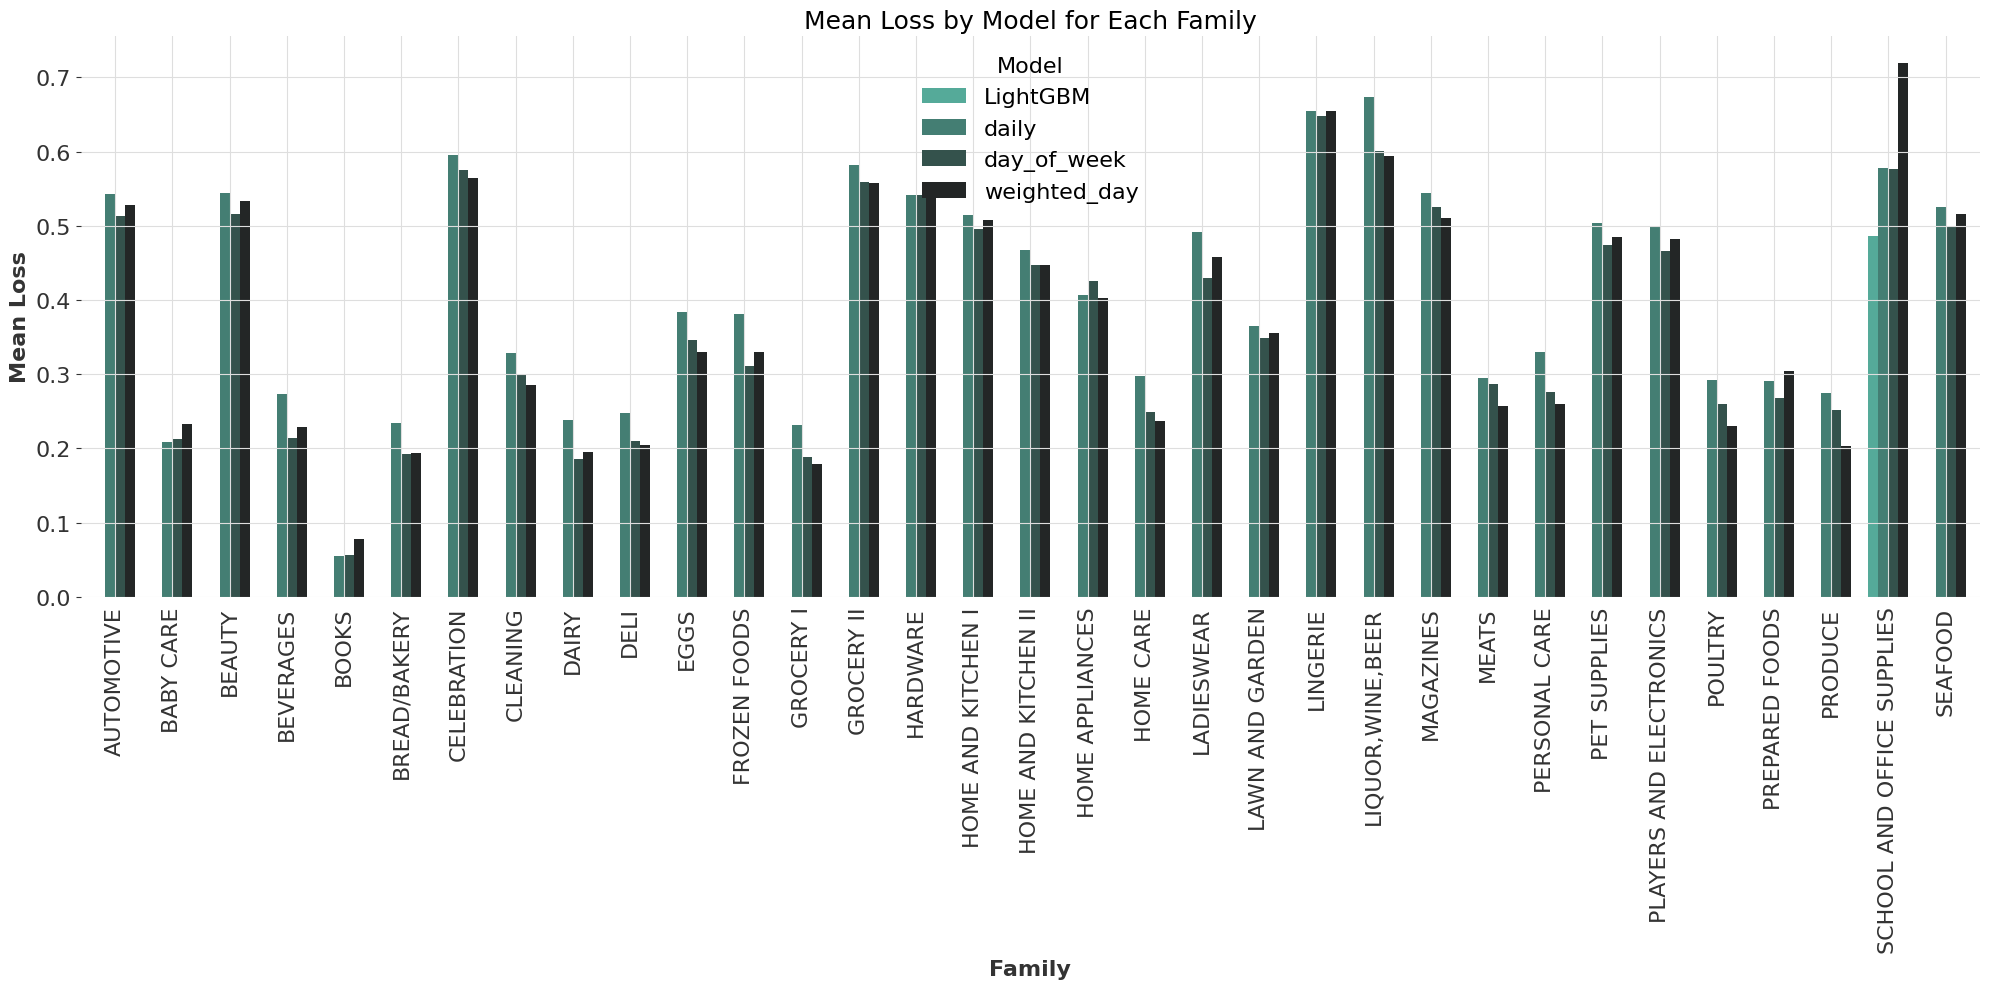

In [37]:
advanced_predictor.make_overall_family_loss_plot()

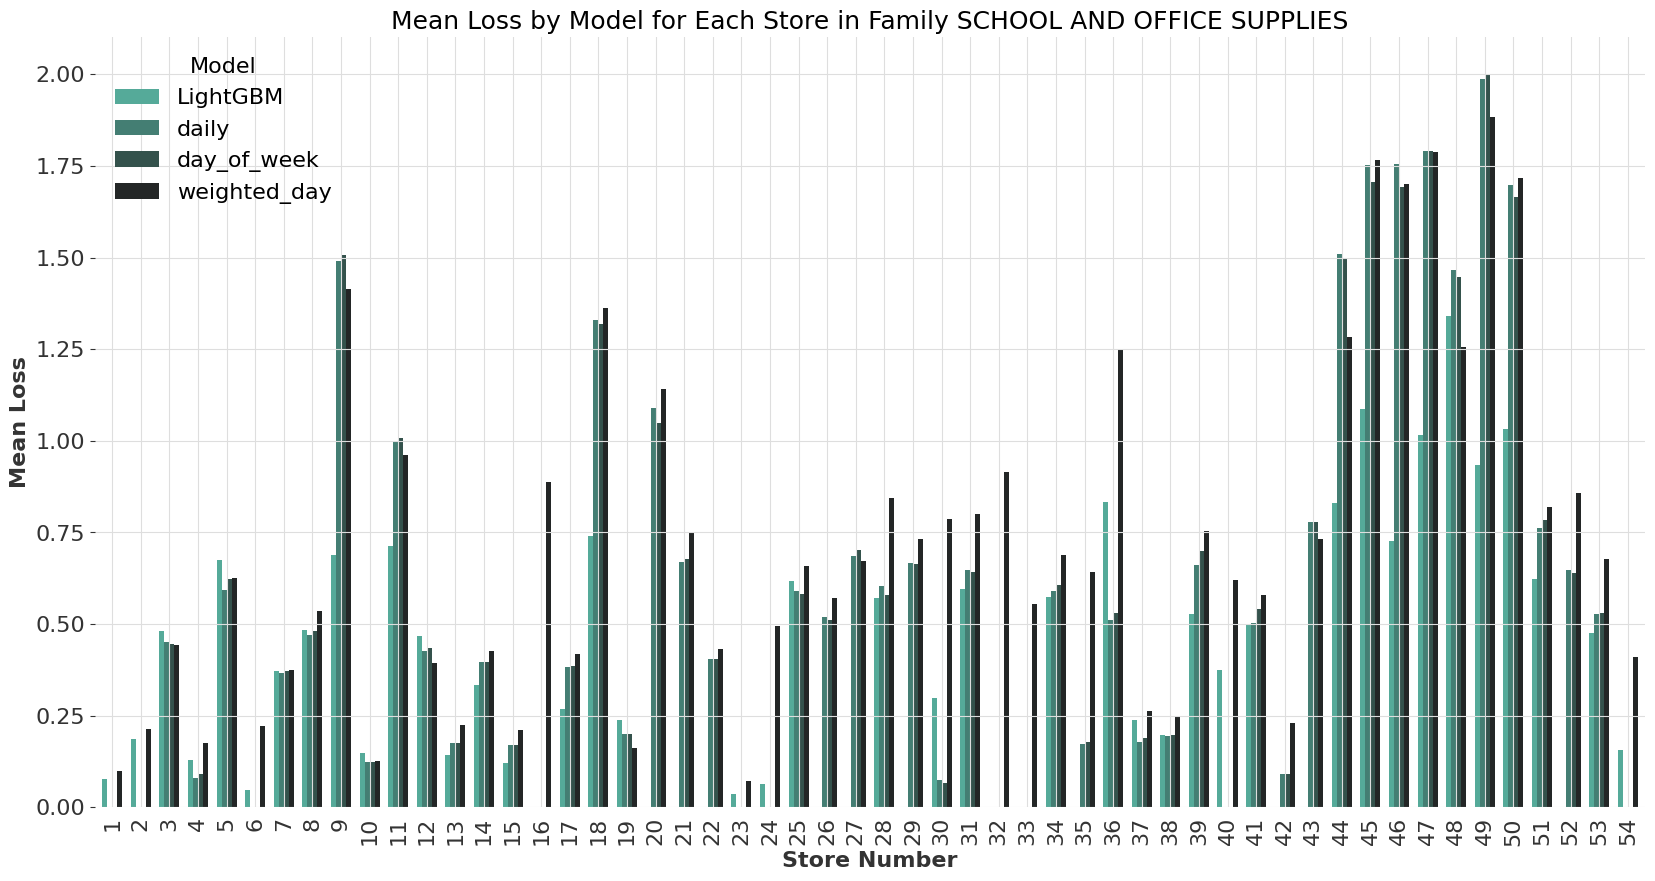

<Figure size 640x480 with 0 Axes>

In [41]:
for family in family_datasets.keys():
    advanced_predictor.make_family_loss_plot(family=family, test_loss=True)

## Save Optimal Submission

In [42]:
# lightgbm_drop_families = ["PREPARED FOODS", "SCHOOL AND OFFICE SUPPLIES"]
lightgbm_drop_families = []
prediction_df = advanced_predictor.get_optimal_prediction(
    lightgbm_drop_families=lightgbm_drop_families
)

In [43]:
submission_file_name = "school_default_model_more_features.csv"

submission_df = save_submission(prediction_df, submission_file_name)

Submission saved to /home/tikhon/PycharmProjects/StoreSales/data/submissions/school_default_model_more_features.csv


### Plot Forecast

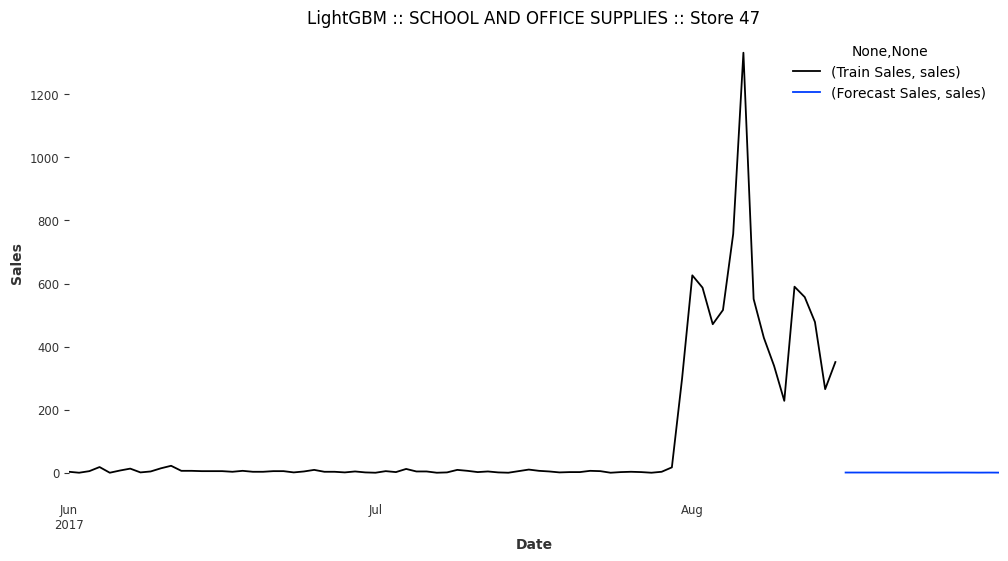

In [50]:
make_submission_forecast_plot(
    train_df=train_df,
    forecast=prediction_df.reset_index(),
    family="SCHOOL AND OFFICE SUPPLIES",
    store_nbr=47,
    drop_before_date=pd.Timestamp("2017-06-01"),
)